In [1]:
import pandas as pd
import numpy as np
import sqlite3
from tqdm import tqdm
import pickle
from pandarallel import pandarallel
from time import time
from tokenizers import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.sparse as sp
from goatools.obo_parser import GODag
from goatools.mapslim import mapslim
from goatools.gosubdag.gosubdag import GoSubDag
import requests
import os
import re
import itertools
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample
from collections import defaultdict
import random

from bertopic import BERTopic
from bertopic.backend import BaseEmbedder
from bertopic.cluster import BaseCluster
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired

from typing import List, Dict, Tuple, Set, Any, Optional, Union

import networkx as nx

from vocabulary_functions import load_tokenizers
from go_functions import (
    create_unit_documents, create_go_labels, create_bertopic_model, 
    create_graph_aware_bertopic_model, split_data, evaluate_go_term_representations, 
    evaluate_go_term_representations_multilabel, compare_tokenization_methods, 
    optimize_graph_aware_parameters, visualize_comparison_results
)

In [2]:
# Initialize pandarallel for parallel processing
pandarallel.initialize(nb_workers=20, progress_bar=True)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
# --- GO DAG and GO Slim Setup ---
ob_url = "http://purl.obolibrary.org/obo/go/go-basic.obo"
obo_path = "go-basic.obo"
if not os.path.exists(obo_path):
    with open(obo_path, "w") as f:
        f.write(requests.get(obo_url).text)
go_dag = GODag(obo_path)

goslim_url = "http://current.geneontology.org/ontology/subsets/goslim_generic.obo"
goslim_path = "goslim_generic.obo"
if not os.path.exists(goslim_path):
    with open(goslim_path, "w") as f:
        f.write(requests.get(goslim_url).text)
goslim_dag = GODag(goslim_path)
goslim_terms = set(goslim_dag.keys())
go_subdag_slim = GoSubDag(goslim_terms, go_dag)
goslim_id2name = {go_id: go_dag[go_id].name for go_id in goslim_terms}
goslim_name2id = {go_dag[go_id].name: go_id for go_id in goslim_terms}

go-basic.obo: fmt(1.2) rel(2025-03-16) 43,544 Terms
goslim_generic.obo: fmt(1.2) rel(go/2025-03-16/subsets/goslim_generic.owl) 206 Terms
 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


In [219]:
# --- Tokenizer and Vocabulary Configuration ---
vocab_sizes = [800, 1600, 3200, 6400, 12800, 25600]
uniref_id = "50"

tokenizer_opts_list = [
    {
        'is_mut': False,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    # {
    #     'is_mut': True,
    #     'dataset': f'uniref{uniref_id}',
    #     'is_pretokenizer': True,
    #     'subs_matrix': 'pam70',
    #     'mutation_cutoff': 0.7,
    #     'min_mutation_freq': 0.05,
    #     'min_mutation_len': 3,
    #     'max_mutation_len': 12,
    #     'vocab_size': vocab_sizes
    # },
]

tokenizer_list = load_tokenizers(tokenizer_opts_list, 'hf')
inner_vocab_list = load_tokenizers(tokenizer_opts_list, 'vocab')

vocab_list = {name: list(set(tok.get_vocab().keys())) for name, tok in tokenizer_list.items()}
methods = [name[:-len(str(vocab_sizes[0]))-1] for name in list(tokenizer_list.keys())[::len(vocab_sizes)]]
methods2names = {mn: mn.replace('mut', 'evo').replace('std', '').replace('blosum', 'BLOSUM').replace('pam', 'PAM').replace('pre', 'Pre') for mn in methods}
methods2names = {k: ' '.join(v.split()[:-2]) if 'evoBPE' in v else v for k, v in methods2names.items()}

In [220]:
# --- Vocabulary Lineage Construction ---
vocab_lineage_list = {}
for k, v in inner_vocab_list.items():
    vocab_lineage_list[k] = {token: {
        'frequency': -1, 'order': -1, 'parent_pair': [], 'parent_mutation': "",
        'parent_mutation_similarity': -1, 'partner_pair_self': False,
        'partner_pair_left': [], 'partner_pair_right': [], 'child_pair': [], 'child_mutation': []
    } for token in v.keys()}

for method_name, vocab in tqdm(inner_vocab_list.items(), desc="Building Vocabulary Lineage"):
    for token, inner_elements in vocab.items():
        lineage = vocab_lineage_list[method_name][token]
        lineage['frequency'] = inner_elements.get('frequency', -1)
        lineage['order'] = inner_elements.get('order', -1)
        lineage['parent_pair'] = inner_elements.get('pair', [])
        lineage['parent_mutation'] = inner_elements.get('parent', "")
        lineage['parent_mutation_similarity'] = inner_elements.get('similarity', -1)

        if 'pair' in inner_elements:
            p1, p2 = inner_elements['pair']
            if p1 == p2:
                vocab_lineage_list[method_name][p1]['partner_pair_self'] = True
                vocab_lineage_list[method_name][p1]['child_pair'].append(token)
            else:
                vocab_lineage_list[method_name][p1]['partner_pair_right'].append(p2)
                vocab_lineage_list[method_name][p2]['partner_pair_left'].append(p1)
                vocab_lineage_list[method_name][p1]['child_pair'].append(token)
                vocab_lineage_list[method_name][p2]['child_pair'].append(token)
        if 'parent' in inner_elements:
            parent = inner_elements['parent']
            vocab_lineage_list[method_name][parent]['child_mutation'].append(token)

Building Vocabulary Lineage: 100%|██████████| 12/12 [00:00<00:00, 75.32it/s]


In [221]:
# --- Database Connection and Data Loading ---
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)

df_protein = pd.read_sql(f"SELECT Entry as uniprot_id, Sequence as sequence FROM proteins WHERE Entry IN (SELECT uniprot_accession FROM uniref{uniref_id}_distilled)", conn)
df_protein = df_protein[df_protein['sequence'].str.len() < 3000].reset_index(drop=True)
df_protein = df_protein[df_protein['sequence'].str.len() > 100].reset_index(drop=True)

df_protein_sliced = pd.read_sql(f"SELECT uniprot_id, sequence FROM uniref{uniref_id}_domain_sliced_plddt70", conn)
df_protein_sliced = df_protein_sliced[df_protein_sliced['uniprot_id'].isin(df_protein['uniprot_id'])].reset_index(drop=True)

df_quickgo = pd.read_sql(f"SELECT uniprot_id, go_id, go_evidence FROM uniprot_quickgo_annotations", conn)
df_quickgo = df_quickgo[df_quickgo['uniprot_id'].isin(df_protein['uniprot_id'])]

# Filter by evidence code
go_evidence_experimental = ['EXP', 'IDA', 'IPI', 'IMP', 'IGI', 'IEP']
go_evidence_computational = ['ISS', 'ISO', 'ISA', 'ISM', 'RCA', 'TAS', 'IEA']
# go_evidence_computational = []
df_quickgo = df_quickgo[df_quickgo['go_evidence'].isin(go_evidence_experimental + go_evidence_computational)].reset_index(drop=True)

# Convert go_ids to go_slim_ids
df_quickgo['go_slim_id'] = df_quickgo['go_id'].apply(lambda x: list(mapslim(x, go_dag, goslim_dag)[0]) if x in go_dag else [])
df_quickgo['go_slim_id'] = df_quickgo['go_slim_id'].apply(lambda x: x[0] if len(x) > 0 else '')
df_quickgo = df_quickgo[df_quickgo['go_slim_id'] != '']

# Drop duplicates
# df_quickgo = df_quickgo.groupby(['uniprot_id', 'go_slim_id']).count().reset_index().sort_values(['uniprot_id', 'go_id'], ascending=False)
df_quickgo = df_quickgo.groupby(['uniprot_id', 'go_slim_id']).agg({'go_id': 'count', 'go_evidence': list}).reset_index().sort_values(['uniprot_id', 'go_id'], ascending=False)
df_quickgo = df_quickgo.drop(columns=['go_id']).rename(columns={'go_slim_id': 'go_id'}).reset_index(drop=True)

# Drop infrequent go terms
df_quickgo = df_quickgo[df_quickgo['go_id'].isin(df_quickgo['go_id'].value_counts()[df_quickgo['go_id'].value_counts() > 100].index)].reset_index(drop=True)

# Add GO term information
df_quickgo['go_name'] = df_quickgo['go_id'].apply(lambda go_id: go_dag[go_id].name)
df_quickgo['go_aspect'] = df_quickgo['go_id'].apply(lambda go_id: go_dag[go_id].namespace)

conn.close()

df_quickgo

,uniprot_id,go_id,go_evidence,go_name,go_aspect
0,X6RLR1,GO:0005730,[IDA],nucleolus,cellular_component
1,X6RLR1,GO:0005829,[IDA],cytosol,cellular_component
2,X6RLN4,GO:0005829,[IDA],cytosol,cellular_component
3,X6RL45,GO:0016787,[IEA],hydrolase activity,molecular_function
4,X6RK96,GO:0003723,"[IEA, IEA]",RNA binding,molecular_function
...,...,...,...,...,...
129689,A0A024QY88,GO:0048018,[IEA],receptor ligand activity,molecular_function
129690,A0A024QY88,GO:0048856,[IEA],anatomical structure development,biological_process
129691,A0A024CHX5,GO:0016787,"[IEA, IEA, IEA]",hydrolase activity,molecular_function
129692,A0A024CHX5,GO:0005576,[IEA],extracellular region,cellular_component


In [222]:
df_quickgo['go_aspect'].value_counts()

go_aspect
cellular_component    50057
biological_process    42730
molecular_function    36907
Name: count, dtype: int64

In [223]:
df_quickgo['go_name'].value_counts()

go_name
nucleus                                     8505
cytosol                                     5954
plasma membrane                             5817
transferase activity                        5305
nucleoplasm                                 5205
                                            ... 
vacuole                                      119
histone binding                              114
regulatory ncRNA-mediated gene silencing     111
renal system process                         110
antioxidant activity                         103
Name: count, Length: 104, dtype: int64

In [224]:
# --- Tokenization and Data Merging ---
for name, tokenizer in tqdm(tokenizer_list.items(), desc="Tokenizing Sequences"):
    if 'pre' in name:
        df_protein_sliced[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein_sliced['sequence'])]
    else:
        df_protein[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein['sequence'])]

df_protein_sliced = df_protein_sliced.groupby('uniprot_id').sum().reset_index()
df_protein = df_protein.set_index(['uniprot_id', 'sequence']).join(df_protein_sliced.set_index(['uniprot_id', 'sequence'])).reset_index()
df_protein_go = pd.merge(df_quickgo, df_protein, how='inner', on='uniprot_id')
df_protein_go

Tokenizing Sequences: 100%|██████████| 12/12 [00:18<00:00,  1.51s/it]


,uniprot_id,go_id,go_evidence,go_name,go_aspect,sequence,BPE 800,BPE 1600,BPE 3200,BPE 6400,BPE 12800,BPE 25600,PUMA blosum62 0.7 0.05 800,PUMA blosum62 0.7 0.05 1600,PUMA blosum62 0.7 0.05 3200,PUMA blosum62 0.7 0.05 6400,PUMA blosum62 0.7 0.05 12800,PUMA blosum62 0.7 0.05 25600
0,X6RLR1,GO:0005730,[IDA],nucleolus,cellular_component,MAGLTDLQRLQARVEELERWVYGPGGARGSRKVADGLVKVQVALGN...,"[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QARV, EEL, ER, WV, YG, PGGA...","[MA, GLT, DL, QRL, QARV, EELER, WV, YG, PGGA, ...","[MA, GL, T, DL, QRL, QA, RV, EEL, ER, WV, YG, ...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QARV, EEL, ER, WV, YG, PGG,..."
1,X6RLR1,GO:0005829,[IDA],cytosol,cellular_component,MAGLTDLQRLQARVEELERWVYGPGGARGSRKVADGLVKVQVALGN...,"[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QARV, EEL, ER, WV, YG, PGGA...","[MA, GLT, DL, QRL, QARV, EELER, WV, YG, PGGA, ...","[MA, GL, T, DL, QRL, QA, RV, EEL, ER, WV, YG, ...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QARV, EEL, ER, WV, YG, PGG,..."
2,X6RLN4,GO:0005829,[IDA],cytosol,cellular_component,EVKGLFKSENCPKVISCEFAHNSNWYITFQSDTDAQQAFKYLREEV...,"[EV, KGL, FK, SEN, C, P, KV, I, SC, E, FA, HN,...","[EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKVI, SC, EFA, HN, SN, W...","[EV, KGL, FK, S, EN, C, P, KV, I, SC, E, FA, H...","[EV, KGL, FK, SEN, C, P, KVI, SC, E, FA, HN, S...","[EV, KGL, FK, SEN, C, P, KVI, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, P, KVI, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKVI, SC, EFA, HN, SN, W...","[EV, KGL, FK, SEN, C, PKVI, SC, EFA, HN, SN, W..."
3,X6RL45,GO:0016787,[IEA],hydrolase activity,molecular_function,MVRCYVEIVEKLPERRPDPATIEGCAQLKPNNYLLAWHTPFNEKGS...,"[MV, RC, YV, EI, V, EKL, PE, RR, PD, PA, TI, E...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PERR, PD, PA, TI, EG, C...","[MV, RC, YV, EIV, EKL, PERR, PDPA, TI, EG, CA,...","[MV, RC, YV, EIV, EKL, PERR, PDPA, TI, EG, CAQ...","[MV, RC, YV, EI, V, EKL, PE, RR, PD, PA, TI, E...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PERR, PD, PA, TI, EG, C...","[MV, RC, YV, EIV, EKL, PERR, PD, PATI, EG, CA,..."
4,X6RK96,GO:0003723,"[IEA, IEA]",RNA binding,molecular_function,TSVNYLDSAFRNIRNLGIVSVTSTDISSLYAKAQHVARRHYGCNIV...,"[T, SV, N, YL, D, SA, FR, NI, RNL, G, IV, SVT,...","[T, SVN, YLD, SA, FR, NI, RNL, G, IV, SVT, ST,...","[T, SVN, YLD, SA, FR, NI, RNL, G, IV, SVT, ST,...","[T, SVN, YLD, SA, FR, NI, RNL, G, IV, SVT, ST,...","[T, SVN, YLD, SA, FRNI, RNLG, IV, SVT, ST, DI,...","[T, SVN, YLD, SA, FRNI, RNLG, IV, SVT, ST, DI,...","[T, SV, N, YL, D, SA, FR, NI, R, NLG, IV, SV, ...","[TSV, N, YL, D, SA, FR, NI, R, NLG, IV, SV, TS...","[TSV, NYL, DSA, FR, NI, R, NLG, IV, SV, TST, D...","[TSV, NYL, DSA, FR, NI, R, NLG, IV, SV, TST, D...","[TSV, NYL, DSA, FR, NI, R, NLG, IVSV, TST, DI,...","[TSV, NYL, DSA, FRNI, R, NLG, IVSV, TST, DI, S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [363]:
import importlib
import go_functions  # import the module first

importlib.reload(go_functions)

from go_functions import (
    create_unit_documents, create_go_labels, create_bertopic_model, 
    create_graph_aware_bertopic_model, split_data, evaluate_go_term_representations, 
    evaluate_go_term_representations_multilabel, compare_tokenization_methods, 
    optimize_graph_aware_parameters, visualize_comparison_results
)

In [ ]:
df_experimental = df_protein_go[df_protein_go['go_evidence'].apply(lambda x: any(e in x for e in go_evidence_experimental))].copy()

threshold = df_experimental['go_name'].value_counts()[:10].mean().astype(int)
go_counts = df_experimental['go_name'].value_counts()

underrepresented_go_names = go_counts[go_counts < threshold].index.tolist()

df_remaining = df_protein_go[~df_protein_go.index.isin(df_experimental.index)].copy()

supplement_rows = []

for go_name in underrepresented_go_names:
    current_count = go_counts[go_name]
    needed = threshold - current_count

    # Bu go_name'e sahip proteinlerden sadece ilk satırlarını seç (random protein seçimi)
    candidate_proteins = df_remaining[df_remaining['go_name'] == go_name]
    
    # Eğer yeterli sayıda protein yoksa, olan kadarını al
    sampled = candidate_proteins.sample(n=min(needed, len(candidate_proteins)), random_state=42)
    
    supplement_rows.append(sampled)

# 6. Tüm takviyeleri birleştir
df_supplement = pd.concat(supplement_rows)
df_balanced = pd.concat([df_experimental, df_supplement])

len(df_experimental), len(df_supplement), len(df_balanced), len(df_protein_go)

(24439, 55958, 80397, 129694)

In [378]:
# --- Single Example ---
# cellular_component, molecular_function, biological_process

df_experimental = df_protein_go[df_protein_go['go_evidence'].apply(lambda x: any(e in x for e in go_evidence_experimental))].copy()

# df = df_protein_go.copy()
df = df_experimental.copy()
# df = df_balanced.copy()

df = df[df['go_id'].isin(df['go_id'].value_counts()[df['go_id'].value_counts() > 0].index)].reset_index(drop=True).copy()
df = df[df['go_aspect'] == 'biological_process'].reset_index(drop=True).copy()
df_train, df_test = split_data(df, 0.4)

# df = df.reset_index(drop=True).copy()
# df = df[df['go_aspect'] == 'molecular_function'].reset_index(drop=True).copy()
# df_train, df_test = split_data(df, 0.2)

# df_train = df[df['go_aspect'] == 'molecular_function'].reset_index(drop=True).copy()
# df_test = df_train.copy()


In [379]:
threshold = df_train['go_name'].value_counts()[:10].mean().astype(int)
go_counts = df_train['go_name'].value_counts()

underrepresented_go_names = go_counts[go_counts < threshold].index.tolist()

df_remaining = df_protein_go[~df_protein_go.index.isin(df_experimental.index)].copy()

supplement_rows = []

for go_name in underrepresented_go_names:
    current_count = go_counts[go_name]
    needed = threshold - current_count

    # Bu go_name'e sahip proteinlerden sadece ilk satırlarını seç (random protein seçimi)
    candidate_proteins = df_remaining[df_remaining['go_name'] == go_name]
    
    # Eğer yeterli sayıda protein yoksa, olan kadarını al
    sampled = candidate_proteins.sample(n=min(needed, len(candidate_proteins)), random_state=42)
    
    supplement_rows.append(sampled)

# 6. Tüm takviyeleri birleştir
df_supplement = pd.concat(supplement_rows)
df_balanced = pd.concat([df_train, df_supplement])

print(threshold, len(df_train), len(df_supplement), len(df_balanced), len(df_protein_go))

df_train = df_balanced.copy()

242 4295 7955 12250 129694


In [380]:
df_train.shape, df_test.shape

((12250, 18), (2817, 18))

In [372]:
df_train.shape, df_test.shape

((26181, 18), (6521, 18))

In [381]:
df_train['go_name'].nunique(), df_train['go_name'].value_counts()

(53,
 go_name
 regulation of DNA-templated transcription                 709
 immune system process                                     282
 anatomical structure development                          242
 chromatin organization                                    242
 transmembrane transport                                   242
 nervous system process                                    242
 protein-containing complex assembly                       242
 cell motility                                             242
 nucleobase-containing small molecule metabolic process    242
 DNA repair                                                242
 defense response to other organism                        242
 vesicle-mediated transport                                242
 protein glycosylation                                     242
 intracellular protein transport                           242
 lipid metabolic process                                   242
 cell adhesion                           

In [382]:
df_test['go_name'].nunique(), df_test['go_name'].value_counts()

(54,
 go_name
 regulation of DNA-templated transcription                 451
 immune system process                                     198
 protein-containing complex assembly                       154
 anatomical structure development                          142
 vesicle-mediated transport                                128
 cell differentiation                                      111
 lipid metabolic process                                   109
 cytoskeleton organization                                  92
 transmembrane transport                                    91
 chromatin organization                                     89
 cell motility                                              88
 protein catabolic process                                  82
 carbohydrate derivative metabolic process                  77
 DNA repair                                                 73
 defense response to other organism                         65
 cell adhesion                           

In [383]:
tokenizer_col = 'PUMA blosum62 0.7 0.05 12800'
go_col = 'go_name'
token_len_thr = 4
top_n_words = 10
raw_sequence_col = 'sequence'
raw_or_tokenized = 'tokenized'
scoring_type = 'freq'
lambda_smooth = 0.7
alpha = 0.3
beta = 0.5
theta = 0.7

unit_relationships = {'hierarchical': {}, 'mutational': {}}
for unit, lineage in vocab_lineage_list[tokenizer_col].items():
    if len(lineage['child_pair']) > 0:
        unit_relationships['hierarchical'][unit] = lineage['child_pair']
    if len(lineage['child_mutation']) > 0:
        unit_relationships['mutational'][unit] = lineage['child_mutation']

documents = create_unit_documents(df_train, tokenizer_col, token_len_thr)
go_labels = create_go_labels(df_train, go_col)

topic_model, _ = create_bertopic_model(documents, go_labels, token_len_thr, top_n_words)
# topic_model, _, similarity_matrix = create_graph_aware_bertopic_model(documents, go_labels, unit_relationships, token_len_thr, top_n_words, lambda_smooth, alpha, beta, theta)

In [376]:
# topic_model.get_topic_info()

In [377]:
evaluation_results = evaluate_go_term_representations(df_test, topic_model, tokenizer_col, go_col, raw_sequence_col, raw_or_tokenized, scoring_type)
print(json.dumps(evaluation_results, indent=2))

Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label):   0%|          | 0/3901 [00:00<?, ?it/s]

Evaluating Test Set (Single-Label): 100%|██████████| 3901/3901 [00:00<00:00, 7112.44it/s]

{
  "accuracy_at_k": {
    "accuracy_at_1": 0.08843886183029992,
    "accuracy_at_3": 0.17585234555242246,
    "accuracy_at_5": 0.26454755190976675,
    "accuracy_at_10": 0.46552166111253523
  },
  "precision_at_k": {
    "precision_at_1": 0.08843886183029992,
    "precision_at_3": 0.05861744851747414,
    "precision_at_5": 0.05290951038195335,
    "precision_at_10": 0.046552166111253526
  },
  "recall_at_k": {
    "recall_at_1": 0.08843886183029992,
    "recall_at_3": 0.17585234555242246,
    "recall_at_5": 0.26454755190976675,
    "recall_at_10": 0.46552166111253523
  },
  "mean_reciprocal_rank": 0.20116667058353477,
  "classification_summary": {
    "accuracy": 0.08843886183029992,
    "macro_avg": {
      "precision": 0.11298060087164874,
      "recall": 0.10431009245717081,
      "f1-score": 0.08048187375656014,
      "support": 3901.0
    },
    "weighted_avg": {
      "precision": 0.18969929027894547,
      "recall": 0.08843886183029992,
      "f1-score": 0.0961920525031568,
   

In [384]:
evaluation_results = evaluate_go_term_representations(df_test, topic_model, tokenizer_col, go_col, raw_sequence_col, raw_or_tokenized, scoring_type)
print(json.dumps(evaluation_results, indent=2))

Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label):   0%|          | 0/1896 [00:00<?, ?it/s]

Evaluating Test Set (Single-Label): 100%|██████████| 1896/1896 [00:00<00:00, 6992.72it/s]

{
  "accuracy_at_k": {
    "accuracy_at_1": 0.0770042194092827,
    "accuracy_at_3": 0.25949367088607594,
    "accuracy_at_5": 0.3697257383966245,
    "accuracy_at_10": 0.5052742616033755
  },
  "precision_at_k": {
    "precision_at_1": 0.0770042194092827,
    "precision_at_3": 0.08649789029535865,
    "precision_at_5": 0.07394514767932489,
    "precision_at_10": 0.05052742616033754
  },
  "recall_at_k": {
    "recall_at_1": 0.0770042194092827,
    "recall_at_3": 0.25949367088607594,
    "recall_at_5": 0.3697257383966245,
    "recall_at_10": 0.5052742616033755
  },
  "mean_reciprocal_rank": 0.22018358360403567,
  "classification_summary": {
    "accuracy": 0.0770042194092827,
    "macro_avg": {
      "precision": 0.039281511259711535,
      "recall": 0.03976475484884374,
      "f1-score": 0.024445453503094336,
      "support": 1896.0
    },
    "weighted_avg": {
      "precision": 0.11149152940905882,
      "recall": 0.0770042194092827,
      "f1-score": 0.06848805055950853,
      "sup

In [217]:
multilabel_evaluation_results = evaluate_go_term_representations_multilabel(df_test, topic_model, tokenizer_col, go_col, raw_sequence_col, raw_or_tokenized, scoring_type)
print(json.dumps(multilabel_evaluation_results, indent=2))

Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label):   0%|          | 0/1543 [00:00<?, ?it/s]

Evaluating Test Set (Multi-Label): 100%|██████████| 1543/1543 [00:00<00:00, 10541.40it/s]


{
  "mean_reciprocal_rank": 0.5417303307556203,
  "accuracy_at_k": {
    "accuracy_at_1": 0.3298768632534025,
    "accuracy_at_3": 0.712248865845755,
    "accuracy_at_5": 0.8088139987038238,
    "accuracy_at_10": 0.9073233959818535
  },
  "precision_at_k": {
    "precision_at_1": 0.3298768632534025,
    "precision_at_3": 0.3117303953337654,
    "precision_at_5": 0.2285158781594297,
    "precision_at_10": 0.14018146467919637
  },
  "recall_at_k": {
    "recall_at_1": 0.22627534487547446,
    "recall_at_3": 0.5921056692281579,
    "recall_at_5": 0.7140928309107182,
    "recall_at_10": 0.8643273770947134
  },
  "classification_summary": {
    "micro_avg": {
      "precision": 0.4095617529880478,
      "recall": 0.4095617529880478,
      "f1-score": 0.4095617529880478,
      "support": 2510.0
    },
    "macro_avg": {
      "precision": 0.12570294217572567,
      "recall": 0.10780077434759905,
      "f1-score": 0.10984466912341163,
      "support": 2510.0
    },
    "weighted_avg": {
     

In [ ]:
# --- Hyperparameter Optimization ---
param_grid = {
    'lambda_smooth': [1.0, 2.0],
    'alpha': [0.5, 1.0, 2.0],
    'beta': [0.5, 1.0, 2.0],
    'theta': [0.5, 1.0, 2.0]
}

tokenizer_col_opt = 'PUMA blosum62 0.7 0.05 6400'
df_opt = df_protein_go[df_protein_go['go_aspect'] == 'molecular_function'].reset_index(drop=True).copy()
df_train_opt, df_test_opt = split_data(df_opt)

if tokenizer_col_opt in tokenizer_list:
    optimization_results, best_parameters, best_param_counter = optimize_graph_aware_parameters(
        df_train=df_train_opt, df_test=df_test_opt, tokenizer_col=tokenizer_col_opt,
        go_col='go_name', vocab_lineage_list=vocab_lineage_list, raw_sequence_col='sequence',
        raw_or_tokenized='tokenized', scoring_type='freq', param_grid=param_grid, token_len_thr=4, top_n_words=10
    )
    display(optimization_results)
else:
    print(f"Tokenizer '{tokenizer_col_opt}' not found.")

Testing 54 parameter combinations for tokenizer: PUMA blosum62 0.7 0.05 6400


Optimizing Parameters:   0%|          | 0/54 [00:00<?, ?it/s]


Testing lambda_smooth=1.0, alpha=0.5, beta=0.5, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9730.70it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:   2%|▏         | 1/54 [00:03<02:42,  3.07s/it]


Testing lambda_smooth=1.0, alpha=0.5, beta=0.5, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9847.58it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:   4%|▎         | 2/54 [00:09<04:09,  4.81s/it]


Testing lambda_smooth=1.0, alpha=0.5, beta=0.5, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9873.74it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:   6%|▌         | 3/54 [00:12<03:24,  4.02s/it]


Testing lambda_smooth=1.0, alpha=0.5, beta=1.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9781.58it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:   7%|▋         | 4/54 [00:15<03:01,  3.64s/it]


Testing lambda_smooth=1.0, alpha=0.5, beta=1.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9909.32it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:   9%|▉         | 5/54 [00:18<02:47,  3.43s/it]


Testing lambda_smooth=1.0, alpha=0.5, beta=1.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9786.40it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  11%|█         | 6/54 [00:21<02:38,  3.30s/it]


Testing lambda_smooth=1.0, alpha=0.5, beta=2.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9585.96it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  13%|█▎        | 7/54 [00:24<02:31,  3.23s/it]


Testing lambda_smooth=1.0, alpha=0.5, beta=2.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9769.64it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  15%|█▍        | 8/54 [00:27<02:26,  3.18s/it]


Testing lambda_smooth=1.0, alpha=0.5, beta=2.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9905.06it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  17%|█▋        | 9/54 [00:30<02:21,  3.15s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=0.5, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9705.94it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  19%|█▊        | 10/54 [00:33<02:17,  3.13s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=0.5, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9804.43it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  20%|██        | 11/54 [00:36<02:13,  3.11s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=0.5, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9862.73it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  22%|██▏       | 12/54 [00:39<02:09,  3.09s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=1.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9881.34it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  24%|██▍       | 13/54 [00:42<02:06,  3.08s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=1.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9855.90it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  26%|██▌       | 14/54 [00:48<02:37,  3.94s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=1.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9862.07it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  28%|██▊       | 15/54 [00:51<02:23,  3.67s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=2.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9869.07it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  30%|██▉       | 16/54 [00:54<02:12,  3.48s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=2.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9807.15it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  31%|███▏      | 17/54 [00:57<02:04,  3.35s/it]


Testing lambda_smooth=1.0, alpha=1.0, beta=2.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9853.16it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  33%|███▎      | 18/54 [01:00<01:57,  3.26s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=0.5, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9724.51it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  35%|███▌      | 19/54 [01:04<01:52,  3.21s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=0.5, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9733.10it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  37%|███▋      | 20/54 [01:07<01:47,  3.18s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=0.5, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9785.63it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  39%|███▉      | 21/54 [01:10<01:43,  3.15s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=1.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9859.09it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  41%|████      | 22/54 [01:13<01:39,  3.12s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=1.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9834.74it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  43%|████▎     | 23/54 [01:16<01:36,  3.10s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=1.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9727.46it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  44%|████▍     | 24/54 [01:19<01:32,  3.09s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=2.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9784.17it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  46%|████▋     | 25/54 [01:22<01:29,  3.09s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=2.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9832.04it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  48%|████▊     | 26/54 [01:25<01:26,  3.08s/it]


Testing lambda_smooth=1.0, alpha=2.0, beta=2.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9669.89it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  50%|█████     | 27/54 [01:31<01:47,  3.96s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=0.5, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9793.15it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  52%|█████▏    | 28/54 [01:34<01:36,  3.70s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=0.5, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9926.45it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  54%|█████▎    | 29/54 [01:37<01:27,  3.51s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=0.5, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9854.12it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  56%|█████▌    | 30/54 [01:40<01:20,  3.37s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=1.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9825.26it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  57%|█████▋    | 31/54 [01:43<01:15,  3.27s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=1.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9887.42it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  59%|█████▉    | 32/54 [01:46<01:10,  3.21s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=1.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9556.51it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  61%|██████    | 33/54 [01:49<01:06,  3.17s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=2.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9847.85it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  63%|██████▎   | 34/54 [01:52<01:02,  3.14s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=2.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9773.28it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  65%|██████▍   | 35/54 [01:56<00:59,  3.12s/it]


Testing lambda_smooth=2.0, alpha=0.5, beta=2.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9718.78it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  67%|██████▋   | 36/54 [01:59<00:56,  3.11s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=0.5, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9833.95it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  69%|██████▊   | 37/54 [02:02<00:52,  3.10s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=0.5, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9846.89it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  70%|███████   | 38/54 [02:05<00:49,  3.09s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=0.5, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9873.93it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  72%|███████▏  | 39/54 [02:11<00:59,  3.96s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=1.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9655.80it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  74%|███████▍  | 40/54 [02:14<00:51,  3.69s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=1.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9934.46it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  76%|███████▌  | 41/54 [02:17<00:45,  3.50s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=1.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9815.52it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  78%|███████▊  | 42/54 [02:20<00:40,  3.38s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=2.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9668.42it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  80%|███████▉  | 43/54 [02:23<00:36,  3.29s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=2.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9855.20it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  81%|████████▏ | 44/54 [02:26<00:32,  3.23s/it]


Testing lambda_smooth=2.0, alpha=1.0, beta=2.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9795.44it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  83%|████████▎ | 45/54 [02:29<00:28,  3.18s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=0.5, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9885.12it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  85%|████████▌ | 46/54 [02:32<00:25,  3.14s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=0.5, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9809.94it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  87%|████████▋ | 47/54 [02:35<00:21,  3.12s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=0.5, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9724.45it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  89%|████████▉ | 48/54 [02:38<00:18,  3.10s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=1.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9843.30it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  91%|█████████ | 49/54 [02:41<00:15,  3.09s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=1.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9886.39it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  93%|█████████▎| 50/54 [02:45<00:12,  3.07s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=1.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9838.89it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  94%|█████████▍| 51/54 [02:50<00:11,  3.93s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=2.0, theta=0.5
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9917.28it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  96%|█████████▋| 52/54 [02:53<00:07,  3.66s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=2.0, theta=1.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9881.38it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters:  98%|█████████▊| 53/54 [02:57<00:03,  3.48s/it]


Testing lambda_smooth=2.0, alpha=2.0, beta=2.0, theta=2.0
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9878.42it/s]


Evaluation mode: tokenized, Scoring type: freq


Optimizing Parameters: 100%|██████████| 54/54 [03:00<00:00,  3.33s/it]


--- Best Parameter Count ---
[('theta_1.0', 3), ('theta_2.0', 2), ('theta_0.5', 1), ('lambda_smooth_2.0', 4), ('lambda_smooth_1.0', 2), ('beta_2.0', 4), ('beta_0.5', 1), ('beta_1.0', 1), ('alpha_0.5', 5), ('alpha_2.0', 1)]


,lambda_smooth,alpha,beta,theta,SL Accuracy at 5,SL Weighted F1,SL MRR,ML Accuracy at 5,ML Weighted F1,ML MRR
0,1.0,0.5,0.5,0.5,0.216332,0.031705,0.128499,0.264900,0.073503,0.156344
1,1.0,0.5,0.5,1.0,0.214192,0.031888,0.128152,0.262430,0.073100,0.156081
2,1.0,0.5,0.5,2.0,0.216332,0.037793,0.131578,0.265229,0.077388,0.159579
3,1.0,0.5,1.0,0.5,0.216167,0.031578,0.128644,0.264570,0.073613,0.156415
4,1.0,0.5,1.0,1.0,0.216332,0.031705,0.128499,0.264900,0.073503,0.156344
5,1.0,0.5,1.0,2.0,0.214521,0.031878,0.128225,0.262595,0.073240,0.156166
6,1.0,0.5,2.0,0.5,0.216003,0.030689,0.128198,0.263747,0.072618,0.155813
7,1.0,0.5,2.0,1.0,0.216332,0.031567,0.128716,0.264570,0.073755,0.156500
8,1.0,0.5,2.0,2.0,0.216497,0.031694,0.128599,0.264900,0.073763,0.156457
9,1.0,1.0,0.5,0.5,0.216167,0.031705,0.128541,0.264735,0.073504,0.156387


In [245]:
# --- Comparison of Tokenization Methods ---
df_comp = df_protein_go[df_protein_go['go_aspect'] == 'molecular_function'].reset_index(drop=True).copy()
df_train_comp, df_test_comp = split_data(df_comp)

tokenizer_cols_comp = list(tokenizer_list.keys())
go_col_comp = 'go_name'
token_len_thr_comp = 4
raw_seq_col_comp = 'sequence'
raw_or_tok_comp = 'tokenized'
scoring_type_comp = 'freq'
lambda_smooth_comp = 1.5
alpha_comp = 0.5
beta_comp = 0.8
theta_comp = 1.0

df_results = compare_tokenization_methods(
    df_train_comp, df_test_comp, tokenizer_cols_comp, go_col_comp, vocab_lineage_list,
    token_len_thr_comp, raw_seq_col_comp, raw_or_tok_comp, scoring_type_comp,
    lambda_smooth_comp, alpha_comp, beta_comp, theta_comp
)
display(df_results)

Comparing Tokenizers:   0%|          | 0/18 [00:00<?, ?it/s]


--- Evaluating Tokenizer: BPE 800 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 15107.22it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 15340.14it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 14873.80it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:   6%|▌         | 1/18 [00:02<00:48,  2.84s/it]


--- Evaluating Tokenizer: BPE 1600 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 10888.34it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 11234.47it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 11272.47it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  11%|█         | 2/18 [00:06<00:51,  3.21s/it]


--- Evaluating Tokenizer: BPE 3200 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9604.73it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9685.18it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9706.44it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  17%|█▋        | 3/18 [00:10<00:53,  3.57s/it]


--- Evaluating Tokenizer: BPE 6400 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9672.99it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9865.41it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9924.96it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  22%|██▏       | 4/18 [00:15<01:00,  4.33s/it]


--- Evaluating Tokenizer: BPE 12800 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9667.50it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9920.76it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:03<00:00, 1714.10it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  28%|██▊       | 5/18 [00:34<02:01,  9.35s/it]


--- Evaluating Tokenizer: BPE 25600 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9808.56it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 10070.88it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9269.80it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  33%|███▎      | 6/18 [01:39<05:42, 28.56s/it]


--- Evaluating Tokenizer: PUMA blosum62 0.7 0.05 800 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9860.54it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 10164.24it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 10092.30it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  39%|███▉      | 7/18 [01:43<03:44, 20.44s/it]


--- Evaluating Tokenizer: PUMA blosum62 0.7 0.05 1600 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9652.23it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9885.41it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9762.73it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  44%|████▍     | 8/18 [01:47<02:31, 15.14s/it]


--- Evaluating Tokenizer: PUMA blosum62 0.7 0.05 3200 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9567.93it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9834.36it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9755.46it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  50%|█████     | 9/18 [01:51<01:44, 11.63s/it]


--- Evaluating Tokenizer: PUMA blosum62 0.7 0.05 6400 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9617.27it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9735.70it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9880.83it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  56%|█████▌    | 10/18 [01:56<01:16,  9.61s/it]


--- Evaluating Tokenizer: PUMA blosum62 0.7 0.05 12800 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9802.49it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9789.08it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9730.31it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  61%|██████    | 11/18 [02:13<01:23, 11.86s/it]


--- Evaluating Tokenizer: PUMA blosum62 0.7 0.05 25600 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9852.01it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9983.17it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9422.06it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  67%|██████▋   | 12/18 [03:11<02:35, 25.98s/it]


--- Evaluating Tokenizer: PUMA pre pam70 0.7 0.05 800 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9666.53it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9827.99it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 10017.33it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  72%|███████▏  | 13/18 [03:15<01:36, 19.27s/it]


--- Evaluating Tokenizer: PUMA pre pam70 0.7 0.05 1600 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9459.09it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 8931.67it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9934.81it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  78%|███████▊  | 14/18 [03:19<00:58, 14.64s/it]


--- Evaluating Tokenizer: PUMA pre pam70 0.7 0.05 3200 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9524.37it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9775.03it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9806.22it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  83%|████████▎ | 15/18 [03:23<00:34, 11.43s/it]


--- Evaluating Tokenizer: PUMA pre pam70 0.7 0.05 6400 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9603.06it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9789.00it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9784.84it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  89%|████████▉ | 16/18 [03:28<00:18,  9.49s/it]


--- Evaluating Tokenizer: PUMA pre pam70 0.7 0.05 12800 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9434.86it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9874.99it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9660.55it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers:  94%|█████████▍| 17/18 [03:42<00:10, 10.81s/it]


--- Evaluating Tokenizer: PUMA pre pam70 0.7 0.05 25600 ---
Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9735.43it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Multi-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9888.99it/s]


Evaluation mode: tokenized, Scoring type: freq


Evaluating Test Set (Single-Label): 100%|██████████| 6074/6074 [00:00<00:00, 9204.92it/s]


Evaluation mode: tokenized, Scoring type: freq


Comparing Tokenizers: 100%|██████████| 18/18 [04:42<00:00, 15.72s/it]


,Tokenizer,Model,SL Accuracy,SL Weighted Precision,SL Weighted Recall,SL Weighted F1,SL Accuracy at 5,SL Precision at 5,SL Recall at 5,SL MRR,ML Accuracy,ML Weighted Precision,ML Weighted Recall,ML Weighted F1,ML Accuracy at 5,ML Precision at 5,ML Recall at 5,ML MRR,Vocab Size
0,BPE 800,Standard BERTopic,0.018933,0.018892,0.018933,0.004414,0.196082,0.039216,0.196082,0.128925,0.051366,0.089387,0.106531,0.060409,0.246460,0.053902,0.174060,0.168569,4
1,BPE 800,Graph-Aware BERTopic,0.018933,0.018532,0.018933,0.004393,0.196082,0.039216,0.196082,0.128627,0.051366,0.100824,0.106531,0.060429,0.246625,0.053935,0.174115,0.168284,4
2,BPE 1600,Standard BERTopic,0.017945,0.074472,0.017945,0.005742,0.191307,0.038261,0.191307,0.126642,0.047580,0.132953,0.097236,0.060387,0.238887,0.051827,0.170858,0.163375,11
3,BPE 1600,Graph-Aware BERTopic,0.017945,0.074472,0.017945,0.005742,0.190319,0.038064,0.190319,0.126212,0.047580,0.141786,0.097358,0.060625,0.238064,0.051696,0.170041,0.162959,11
4,BPE 3200,Standard BERTopic,0.028317,0.090287,0.028317,0.032885,0.199210,0.039842,0.199210,0.126111,0.042805,0.144898,0.068860,0.074595,0.247448,0.053507,0.182450,0.152743,472
5,BPE 3200,Graph-Aware BERTopic,0.028976,0.095468,0.028976,0.033939,0.201021,0.040204,0.201021,0.126811,0.043793,0.146580,0.068249,0.074364,0.249259,0.053935,0.184055,0.153522,472
6,BPE 6400,Standard BERTopic,0.025519,0.074367,0.025519,0.028515,0.213533,0.042707,0.213533,0.128018,0.038196,0.136240,0.076443,0.074646,0.260454,0.056338,0.190669,0.154435,2923
7,BPE 6400,Graph-Aware BERTopic,0.025025,0.070626,0.025025,0.027471,0.215673,0.043135,0.215673,0.128032,0.037866,0.136868,0.077422,0.075644,0.263253,0.056964,0.192989,0.154779,2923
8,BPE 12800,Standard BERTopic,0.022720,0.079810,0.022720,0.024570,0.220448,0.044090,0.220448,0.129335,0.039183,0.146650,0.085005,0.075657,0.270333,0.058874,0.195905,0.158470,8664
9,BPE 12800,Graph-Aware BERTopic,0.022391,0.079260,0.022391,0.023951,0.216003,0.043201,0.216003,0.128731,0.039513,0.147365,0.085372,0.075751,0.265887,0.057853,0.192771,0.158246,8664


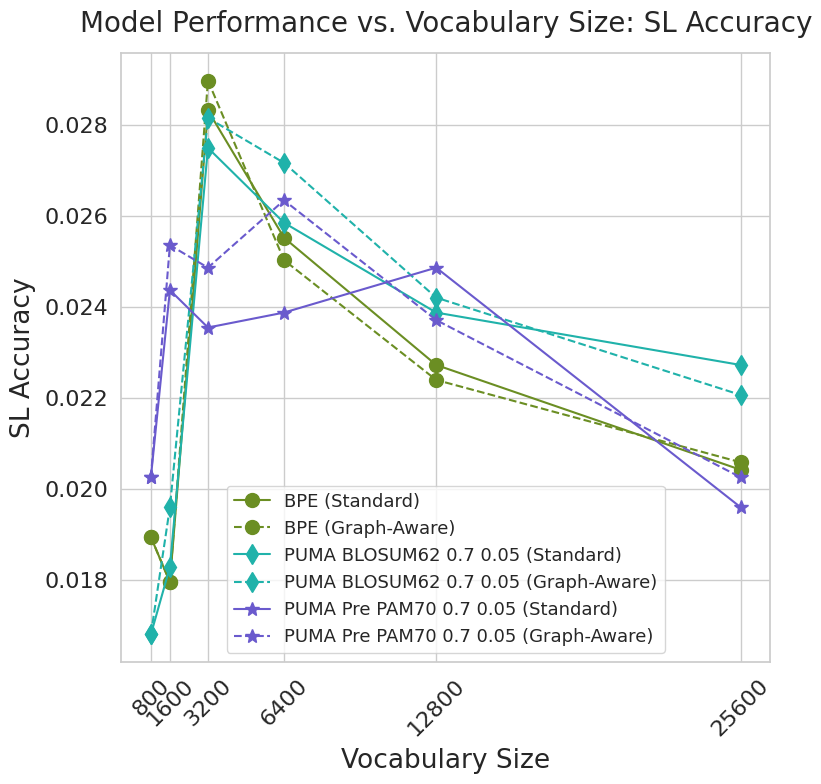

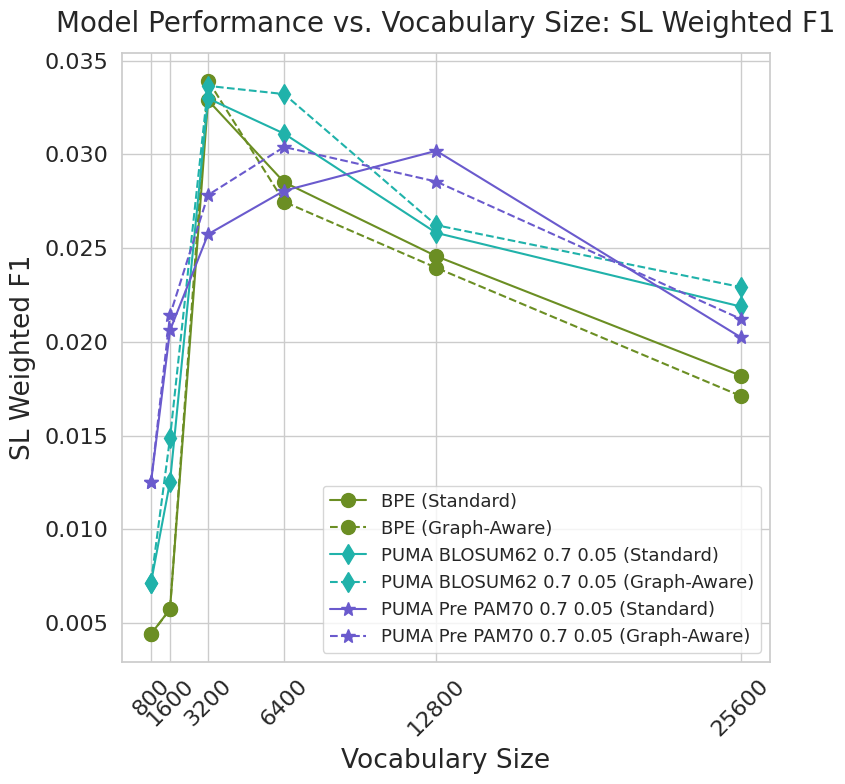

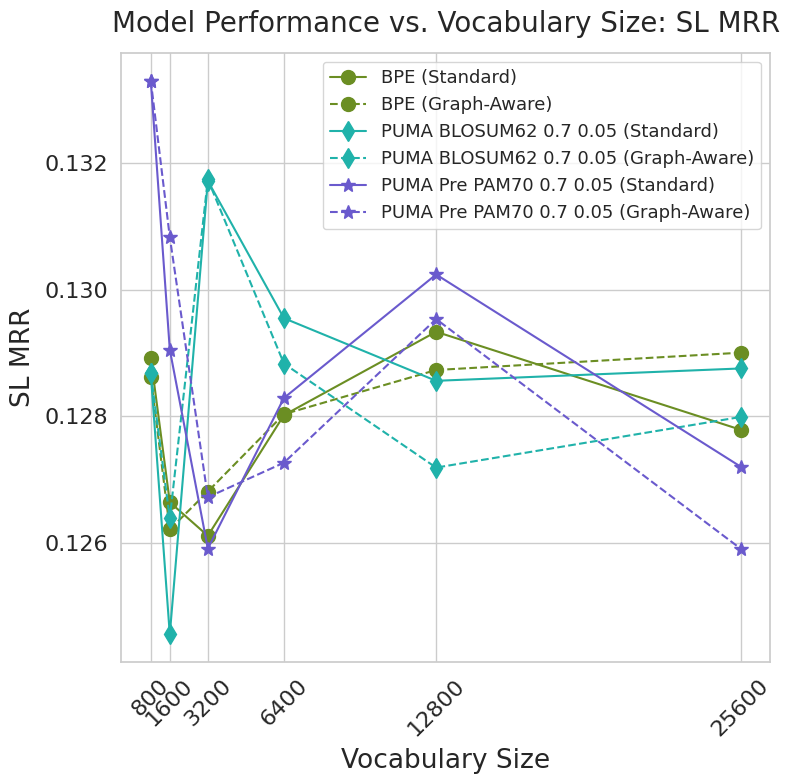

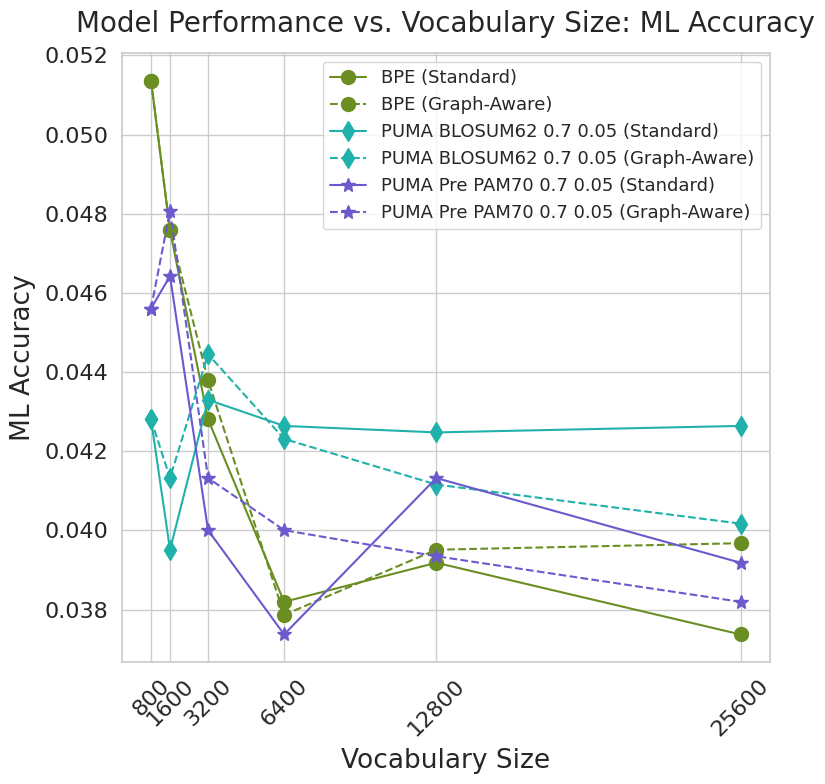

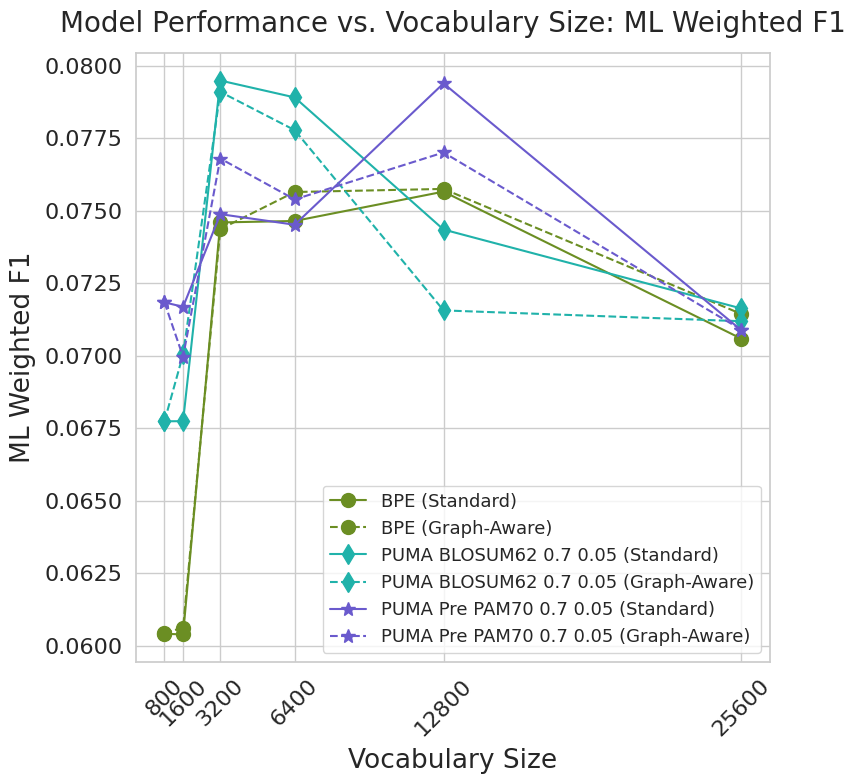

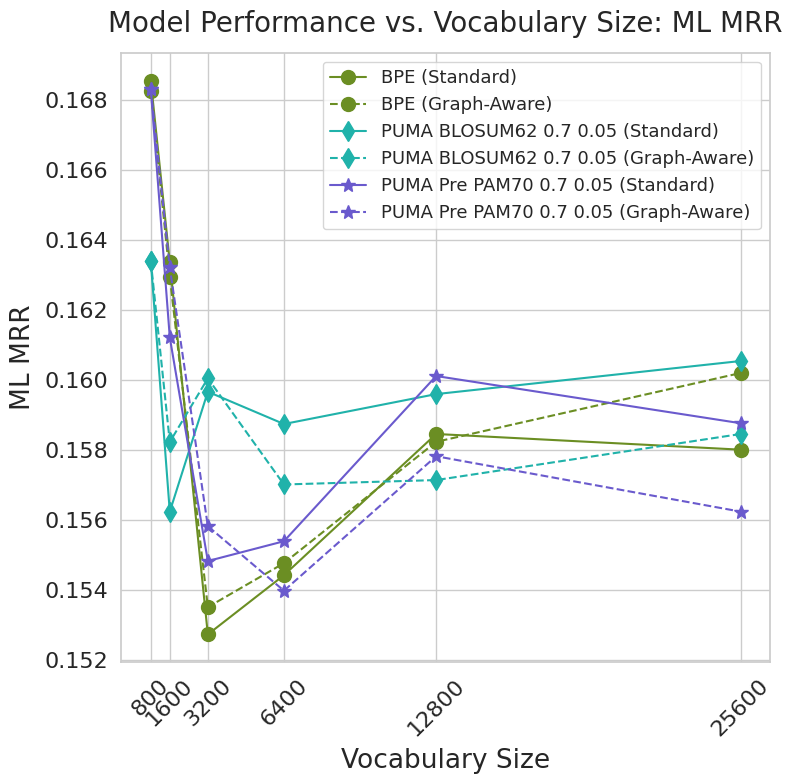

In [246]:
visualize_comparison_results(df_results[['Tokenizer', 'Model', 'SL Accuracy', 'SL Weighted F1', 'SL MRR', 'ML Accuracy', 'ML Weighted F1', 'ML MRR']], methods, methods2names, vocab_sizes)